In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import AlexNet_Weights
import torchvision.models as models
import torchsummary
import matplotlib.pyplot as plt
from torchvision.models import alexnet
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import alexnet
from torchvision import transforms

In [19]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Step 1: Import the pre-trained AlexNet
alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT).to(device)
torchsummary.summary(alexnet, input_size=(3, 224, 224))

# Step 2: Remove the last three layers
alexnet.classifier = nn.Sequential(*list(alexnet.classifier.children())[:-3])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [21]:
# Step 3: Add layers for classification
new_layers = nn.Sequential(
    nn.Linear(4096, 256),
    nn.ReLU(),
    nn.Linear(256, 5),
    nn.Softmax(dim=1)
)
alexnet.classifier.add_module('new_layers', new_layers)

In [22]:
# Step 4: Load and preprocess your dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [23]:
dataset = ImageFolder("D:\\Development\\DeepLearning\\data\\lung_colon_image_set", transform=transform)
dataset.samples = [(path, target) for path, target in dataset.samples if path is not None]

In [24]:
# Step 5: Train and evaluate the model
batch_size = 128
learning_rate = 0.001
num_epochs = 5

In [25]:
# Split dataset into training and testing sets
train_size = len(dataset) // 2
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [26]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=learning_rate)

In [28]:
# Move the model to the device
alexnet = alexnet.to(device)

In [29]:
# Train the model
train_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0

    # Training loop
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = alexnet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Print progress
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}")

Epoch [1/5], Train Loss: 1.3036
Epoch [2/5], Train Loss: 1.3006
Epoch [3/5], Train Loss: 1.2996
Epoch [4/5], Train Loss: 1.3006
Epoch [5/5], Train Loss: 1.2998


In [30]:
# Evaluate the model
alexnet.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = total_correct / total_samples
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 59.50%


In [31]:
# Model summary
torchsummary.summary(alexnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

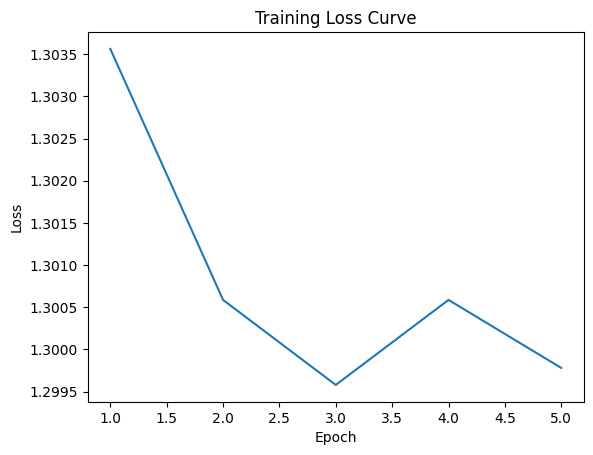

In [32]:
# Plotting the loss curve
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

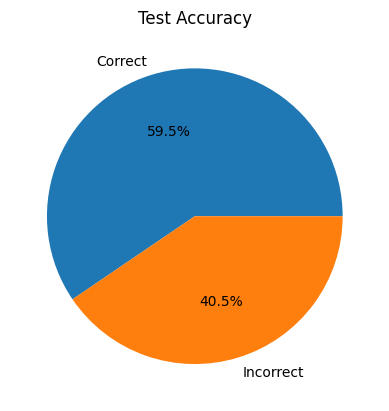

In [33]:
# Accuracy
labels = ['Correct', 'Incorrect']
sizes = [total_correct, total_samples - total_correct]

plt.figure()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Test Accuracy')
plt.show()